In [16]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from IPython.display import Video

from generate_movies import runlength_decode

# Abstract

This project consists of a complete implementation of a framework to study the evolution of a Cellular Automata. The framework allows to simulate two versions of Conway's Game of Life, introducing stochasticity in the birth and the death of the cells: we consider a traditional 8-cells neighbourhood and a 4-cells VonNeumann neighbourhood. The simulations show interesting patterns and a significant impact of the stochastic parameters associated to birth and death.

# Introduction
The class of problems of Cellular Automata was introduced in the 20th century by some mathematicians. Since CA is interpretable as the evolution over time of a population, there is no limit to the number of dimensions in the problem. However, for the sake of simplicity, this work is intended for bidimensional and finite regions. Every region is hence considered as a rectangular grid of $N$ rows and $M$ columns, named board. The squares of the board are called cells.

Like every automaton, CA problems are defined by a finite set of states for each cell in the grid. The time is discrete and, given a configuration, a set of rules determines the configuration of the following time step. These rules are constant over time and identical for all the cells in the board.

## Evolution rules
The rules that determine the update of a cell are functions of its neighbourhood. In this framework, the neighbourhood is limited to the Moore neighbourhood (see Figure below). Therefor, given $\mathbb{S}$ the set of possible states, every rule is a function $f: \mathbb{S}^9 \rightarrow \mathbb{S}$.

![alt text](images/Moore.png "Title")

The user can define custom rules based on every subset of the Moore neighbourhood, by just ignoring some cells. For example, the VonNeumann neighbourhood (see Figure below) is obtainable by a simple restriction of the rules to the domain $\mathbb{S}^5$.

![alt text](images/vonNeumann.png "Title")

The edges of the board are critical zones, since the neighbourhoods of their cells are not completely defined. In this framework, the 2D-support is considered as toroidal: the last row (column) is considered
adjacent to the first row (column).

![alt text](images/toroid.png "Title")

The most famous version of CA is the Conway's Game of Life. Every cell has two possible states: dead or alive. The state transitions are based on its 8 Moore neighbours:

- Any alive cell dies by underpopulation it it has 1 or 0 alive neighbours.
- Any alive cell survives if it has 2 or 3 live neighbours.
- Any alive cell dies by overpopulation if it has 4 or more alive neighbours.
- Any dead cell becomes alive by reproduction, if it has 3 alive neighbours. Otherwise, it remains dead.

By introducing a stochastic probability of cell death, Yaroslavsky (2013) identified the formation of maze-like structures with chaotic dislocations. Our goal is to evaluate the impact of the stochastic hyperparameters on the stability and the density of these structures.

Moreover, with a particular set of rules on a 1-dimensional grid, Monetti and Albano (1997) observed that,defined several possible asymptotic states of the population:
- Extinction
- Overcrowding
- Chaotic life
- Frozen life

We will try to reuse these definitions to label the asymptotic states of the simulated populations.

## Problem Formulation

We consider a 2-dimensional squared board with sides N = 100, M = 100. 

To relate our simulations with the states introduced by Monetti and Albano (1997), we introduce two quantitative metrics:

- Density, defined as $d_t = \frac{aliveCells(t)}{M*N}$

- Stability, defined as $s_t = 1 - \frac{updatedCells(t)}{M*N}$. updatedCells(t) counts the cells which changed state from $t-1$ to $t$.

A key component of the simulation is the configuration at $t_0$. In our case, we initialize the board with a [Gosper Glider Gun](https://conwaylife.com/wiki/Gosper_glider_gun).

## The framework

For performance reasons, our framework for defining rules and running simulations is written in C++. It is entirely located in './code'. We implemented the entire simulator from scratch, only relying on the [C++ Standard Library](https://en.cppreference.com/w/cpp/header) (i.e. without any external library).

Some additional Python scripts and notebooks are included in this repo to generate the videos of the simulations and retrieve some metrics.


From a performance point of view, we apply to optimization techniques:
- To speedup the simulation phase, we apply multithreading, leveraging [std::thread](https://m.cplusplus.com/reference/thread/thread/).
- In order to save space, the simulations run with C++ are stored into txt files (in folder './results') through RunLenght binary encoding, implemented from scratch inside [Board::getEncodedBoard](code/board.cpp).

The framework can be easily extended by implementing other subclasses of the abstract classes [Solver](code/solvers.h) and [UpdateRule](code/rules.h).

The basic usage of the framework is the following:
- compile and build C++ code with CMake through the script './maker.sh'
- run simulations and generate plots, for instance through the script './run_simulations.sh'

# Rules implementation

This paragraph defines the two rules considered during the experiments: Stochastic and VonNeumann.

### Stochastic Version
The stochastic version considers the 8 Moore neighbours and follows this set of rules:
- Any alive cell with 1 or 0 alive neighbours (underpopulation) or 4 or more alive neighbours (overpopulation) dies with probability $p_{death}$.
- Any alive cell survives if it has 2 or 3 alive neighbours.
- Any dead cell becomes alive by reproduction if it has 3 alive neighbours or, with probability $p_{birth}$, if it has 2 alive neighbours. Otherwise it remains dead.

### VonNeumann Version
The VonNeumann Version, inspired by the 1-dimensional rules defined by Monetti and Albano (1997), considers the 4 VonNeumann neighbours and the following set of rules:

- Any alive cell with 2 or 3 alive neighbours (overpopulation) dies with probability $p_{death}$.
- Any alive cell survives if it has 0 or 1 alive neighbours.
- Any dead cell becomes alive by reproduction if it has 2 alive neighbours or, with probability $p_{birth}$, if it has 1 alive neighbour. Otherwise it remains dead.

# Software assessment
The framework is assessed by running a simulation with the original Stochastic Rule, setting $p_{death} = 1$ and $p_{birth} = 0$. The evolution of the system follows the expected behaviour of the Gosper Glider Gun. The toroidal edges allow the gliders to circulate on the board, generating collisions between the gliders and the gun, which is finally destroyed by its own descendants.

In [17]:
Video("videos/Stochastic_1.0_0.0.mp4")

# Experimental results
For both the rules we run a 2D grid of simulation, where the dimensions correspond to $p_{death}$ and $p_{birth}$. Since the possible values are [0, 0.2, 0.4, 0.6, 0.8, 1] for both the parameters, the final grids have size 25.

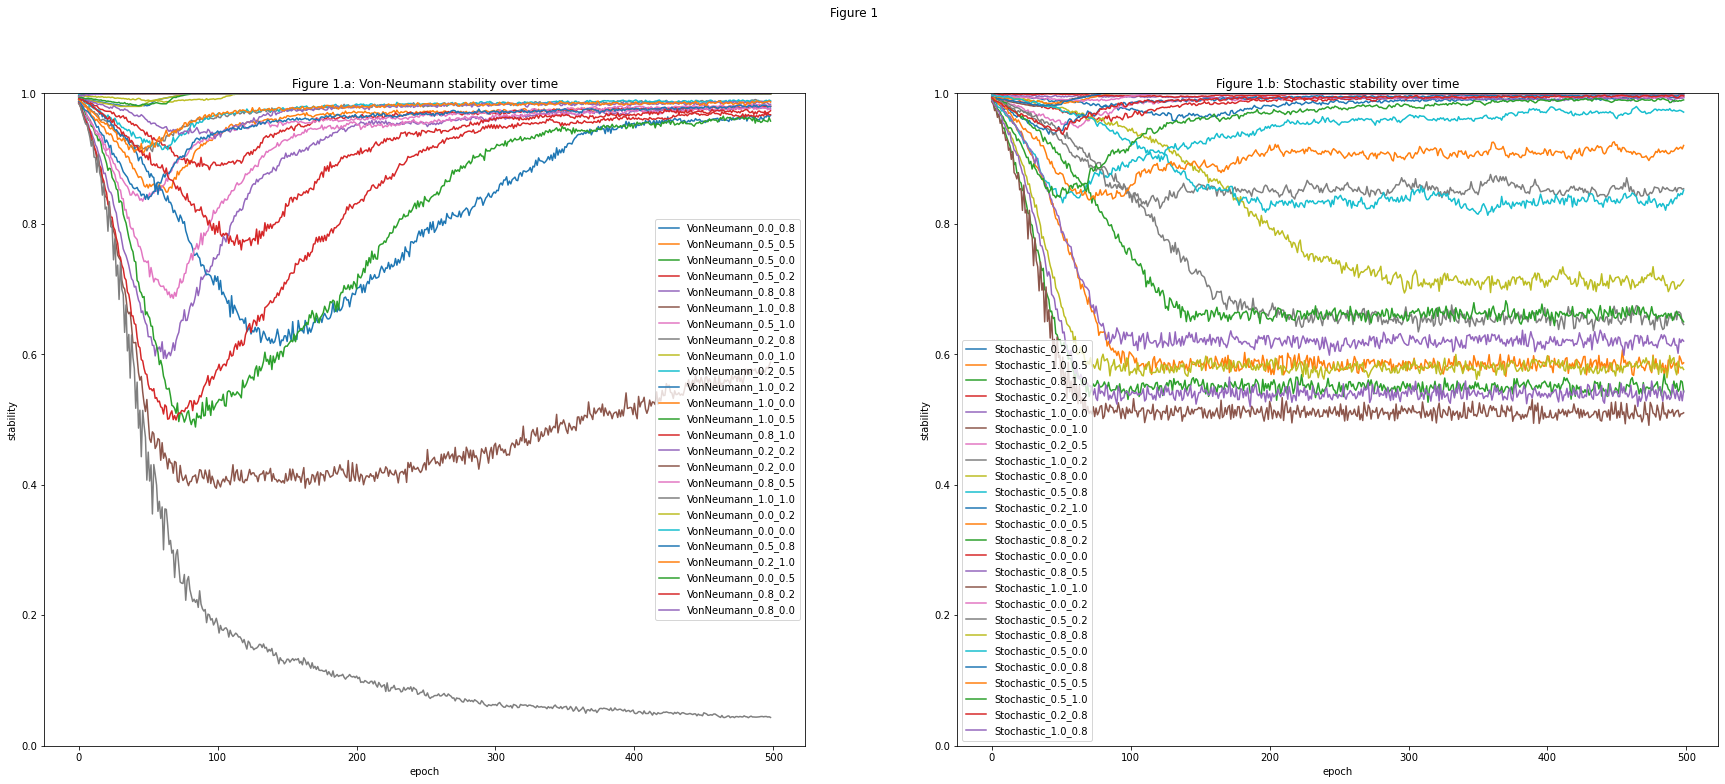

In [18]:
df = pd.DataFrame(columns = ['rule', 'p_death', 'p_birth', 'density', 'stability'])
final_epochs = 100
rules = ['VonNeumann', 'Stochastic']
plots_folder = 'stability_plots'

N = 100
fig, axs = plt.subplots(1, 2, figsize=(30,12))

for plot_index, rule in enumerate(rules):
    filenames = [x[:-4] for x in os.listdir(os.path.join('results', rule))]
    for filename in filenames:
        grids = []
        with open(os.path.join('results', rule, filename+'.txt')) as file:
            for line in file:
                grids.append(runlength_decode([int(number) for number in line.split(', ')], N).ravel())
        grids = np.stack(grids, axis=0)
        stability_in_time = 1 - np.abs(np.diff(grids, axis=0)).mean(axis=1)
        axs[plot_index].plot(stability_in_time, label=filename)
        _, p_d, p_b = filename.split('_')
        d = grids[-final_epochs:, :].mean()
        s = stability_in_time[-final_epochs:].mean()
        sim = {'rule': rule, 'p_death': p_d, 'p_birth': p_b, 'density': d, 'stability': s}
        df = df.append(sim, ignore_index=True)
    axs[plot_index].set_xlabel('epoch')
    axs[plot_index].set_ylabel('stability')
    axs[plot_index].set_ylim(0,1)
    axs[plot_index].legend()
axs[0].set_title('Figure 1.a: VonNeumann stability over time')
axs[1].set_title('Figure 1.b: Stochastic stability over time')

fig.suptitle("Figure 1")
plt.show()

Figure 1.a shows how the asymptotical behaviour of the VonNeumann rule is generally stable, with only 2 simulations showing a significant variability in the cell states.
On the other hand, Figure 1.b depicts a very different scenario, where stabilities are well scattered in the interval [0.5, 1].

To relate the evolutive states discribed by Monetti and Albano (1997) with the parameters, we plot the heatmaps of the asymptotic densities and stabilties with respect to $p_{death}$ and $p_{birth}$. We evaluate the average Density and Stability over the last 100 epochs of each simulation, consisting of 500 epochs.

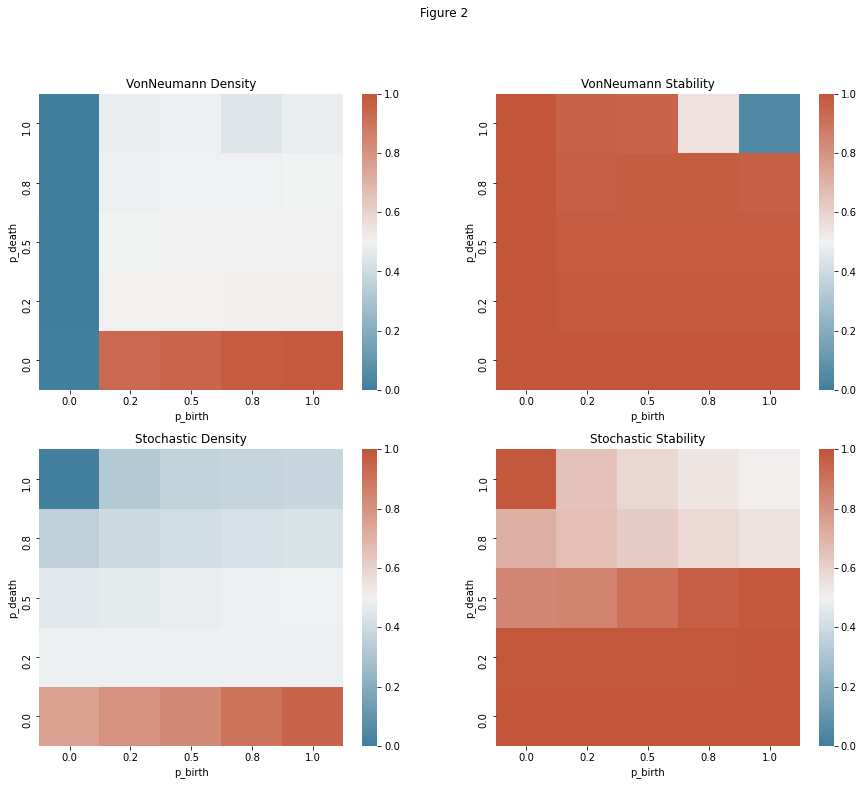

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(15,12))
summary_axes = axes.ravel()

vmin=0
vmax=1
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df[df.rule.eq('VonNeumann')].pivot("p_death", "p_birth", "density"), ax=summary_axes[0], cmap=cmap, vmin=vmin, vmax=vmax)
sns.heatmap(df[df.rule.eq('VonNeumann')].pivot("p_death", "p_birth", "stability"), ax=summary_axes[1], cmap=cmap, vmin=vmin, vmax=vmax)
sns.heatmap(df[df.rule.eq('Stochastic')].pivot("p_death", "p_birth", "density"), ax=summary_axes[2], cmap=cmap, vmin=vmin, vmax=vmax)
sns.heatmap(df[df.rule.eq('Stochastic')].pivot("p_death", "p_birth", "stability"), ax=summary_axes[3], cmap=cmap, vmin=vmin, vmax=vmax)

for a in summary_axes:
    a.invert_yaxis()

summary_axes[0].set_title('VonNeumann Density')
summary_axes[1].set_title('VonNeumann Stability')
summary_axes[2].set_title('Stochastic Density')
summary_axes[3].set_title('Stochastic Stability')
fig.suptitle("Figure 2")
plt.show()

A first impression provided by Figure 2 is certainly that the 4-dimensional neighbourhood of the VonNeumann rule often leads to asymptotic stability, whereas the 8-dimensional neighbourhood of the Stochastic rule introduces more variability.

In the next paragraphs we propose a deeper focus on the single simulations, trying to label them with the evolutive states proposed by Monetti and Albano (1997).

## VonNeumann Rule

The VonNeumann heatmaps provide neat boundaries betweeen evolutive states:
- $p_{birth} = 0$ leads to **stable underpopulation**

In [20]:
Video("videos/VonNeumann_0.5_0.0.mp4")

- $p_{death} = 0 \wedge p_{birth} \in [0.25, 1]$ leads to **stable overpopulation**. Note how the spreading of the population follows a reticular pattern, typical of the 4-dimensional neighbourhood

In [21]:
Video("videos/VonNeumann_0.0_0.5.mp4")

- $p_{death} \in [0.25, 1] \wedge p_{birth} \in [0.25, 1]$ generally leads to **stable life**. It is curious to notice how some cahotic *dendrils* flow inside a stable pattern which resembles a checkboard. This state appears quite similar to what Monetti and Albano (1997) define **frozen life**.

In [22]:
Video("videos/VonNeumann_0.5_0.5.mp4")

The subgrid above contains two exceptions:
- $p_{death} = 1 \wedge p_{birth} = 1$ presents **extremely cahotic life**, with a maze-like structure.

- $p_{death} = 1 \wedge p_{birth} = 0.8$ present **cahotic life** as well, but the final part of the simulation shows an interesting evolution: some stable clusters start taking shape.

In [23]:
Video("videos/VonNeumann_1.0_1.0.mp4")

In [24]:
Video("videos/VonNeumann_1.0_0.8.mp4")

## Stochastic Rule

- As discussed before, the configuration $p_{death}= 1 \wedge p_{birth} = 0$ corresponds to the non-stochastic Conway's Game of Life.

- For $p_{death} = 0$, the population reaches a **stable overpopulation**.

In [25]:
Video("videos/Stochastic_0.0_0.8.mp4")

- For $p_{death} \in [0.2, 0.5]$, we clearly see the **quasi-stable maze** pattern obtained by Yaroslavsky (2013).

In [26]:
Video("videos/Stochastic_0.2_0.8.mp4")

- For $p_{death} \in [0.8, 1]$, we obtain  **cahotic maze** patterns.

In [15]:
Video("videos/Stochastic_0.8_0.8.mp4")

# Conclusion



The introduction of stochastic births and deaths in Conway's Game of Life corrupts the well-known pattern of a Gosper Glider Gun, which is only stable in the non-stochastic version. Stochastic simulations, however, present some interesting asymptotic states, which are strongly related to the probablities $p_{death}$ and $p_{birth}$. Our results are well aligned with the literature and include most of the evolutive states mentioned by the authors we cited.

# References

[Yaroslavsky, Leonid,
(2013),
*The amazing dynamics of stochastic pattern formation and growth models inspired by the Conway's Game of Life*,
arXiv
](https://arxiv.org/abs/1304.8104)

[Roberto A. Monetti and Albano, Ezequiel V. Albano,
(1997),
*Stochastic game of life in one dimension*,
Physica A: Statistical Mechanics and its Applications,
Volume 234, Issues 3–4,
Pages 785-791](https://arxiv.org/abs/1304.8104)